In [199]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import requests
from sklearn.model_selection import train_test_split
from statistics import mean
import time
from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import warnings
from collections import Counter
import pandas as pd
import pubchempy as pcp
from sklearn.metrics import jaccard_score
from itertools import combinations
import pubchempy as pcp
from collections import Counter
import numpy as np
from sklearn.metrics import jaccard_score
import requests
from tqdm import tqdm
import pandas as pd
from statistics import mean
from bs4 import BeautifulSoup
import json
import csv
from tqdm import tqdm
import pandas as pd 
from io import StringIO
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split
import re
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
#plotting packages
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
#metrics
import math
from statistics import mean, stdev
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
# Ignore all warnings
warnings.filterwarnings('ignore')

  ### Outline
  
- [Methods](#0)
- [Loading Datasets](#1)
- [Evaluation](#3)
    - [Ratio 1:1](#3.1)
    - [Ratio 1:5](#3.2)        
    - [Ratio 1:10](#3.3)        

# 

<a name="0"></a>
**Methods**

In [200]:
def remove_labels_with_numbers(text):
    # Use a regular expression to remove numbers that appear as labels
    return re.sub(r'\d+', '', text)

In [201]:
def similarity_smile(smiles1,smiles2):
    score = 0
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # Change radius as needed
        fp2 = AllChem.GetMorganFingerprint(mol2, 2)  # Change radius as needed
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        score = tanimoto_similarity
    else:
        score = -1
    return score

In [202]:
def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Function to count k-mers
def count_kmers(kmers):
    return Counter(kmers)

# Function to calculate similarity score
def calculate_similarity(seq1, seq2, k):
    kmers_seq1 = generate_kmers(seq1, k)
    kmers_seq2 = generate_kmers(seq2, k)
    
    count_kmers_seq1 = count_kmers(kmers_seq1)
    count_kmers_seq2 = count_kmers(kmers_seq2)
    
    common_kmers = set(count_kmers_seq1.keys()) & set(count_kmers_seq2.keys())
    common_count = sum(min(count_kmers_seq1[kmer], count_kmers_seq2[kmer]) for kmer in common_kmers)
    total_count = sum(count_kmers_seq1.values()) + sum(count_kmers_seq2.values())
    
    similarity = common_count / total_count
    return similarity

In [203]:
def generate_random_combinations(num_combinations, all_drugs, all_targets, df_original):
    # Generate all possible combinations
    all_combinations = pd.MultiIndex.from_product([all_targets, all_drugs], names=['Protein', 'Drug']).to_frame(index=False)
    
    # Drop combinations that are in the original DataFrame
    filtered_combinations = all_combinations[~all_combinations.set_index(['Protein', 'Drug']).index.isin(df_original.set_index(['Protein', 'Drug']).index)]
    
    # Sample randomly from the filtered combinations
    sampled_combinations = filtered_combinations.sample(n=num_combinations, random_state=42)
    
    # Create the label column
    sampled_combinations['Label'] = 0
    
    return sampled_combinations


In [204]:
def confusionMat_v2(Y_test, y_pred, y_prob, modelName):
    cf_matrix = confusion_matrix(Y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    fpr, tpr, thresh = roc_curve(Y_test, y_prob, pos_label=1)
    auc = roc_auc_score(Y_test, y_prob)
    

    auprc = average_precision_score(Y_test, y_prob)
    precision_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])
    recall_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

    precision_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[0, 1])
    recall_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[1, 0])

    accuracy = accuracy_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print("\n", modelName, "...................................\n") 
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("AUPRC:", auprc)
    print("AUROC:", auc)
    print("PrecisionClass0:", precision_class0)
    print("RecallClass0:", recall_class0)
    print("PrecisionClass1:", precision_class1)
    print("RecallClass1:", recall_class1)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax[0])
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_test, y_pred, zero_division=1))
    return auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1,cf_matrix[1, 1]

In [205]:
columns = ['Data','AUPRC', 'AUROC', 'PrecisionClass0', 'RecallClass0', 'PrecisionClass1', 'RecallClass1', 'Accuracy', 'F1']
metricTable= pd.DataFrame(columns=columns)
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1


# 

<a name="1"></a>
**Loading Datasets**

- Mapping

In [206]:
mapping = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Mapping/gpcr_admat_dgc.csv")
mapping

,Protein,Drug
0,hsa338442,D00049
1,hsa1812,D00059
2,hsa1813,D00059
3,hsa5739,D00079
4,hsa9052,D00094
...,...,...
630,hsa3352,D05740
631,hsa154,D05792
632,hsa4988,D05938
633,hsa3360,D06056


In [207]:
all_drugs = mapping['Drug'].unique().tolist()
all_targets = mapping['Protein'].unique().tolist()

- Features

In [208]:
smile_drug = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/drugs_smile.csv")
smile_drug

,DrugID,SMILE
0,D00049,OC(=O)C1=CN=CC=C1
1,D00059,N[C@@H](CC1=CC(O)=C(O)C=C1)C(O)=O
2,D00079,CCCCC[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C@@H]1C...
3,D00094,C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C/C(O)=O
4,D00095,CNC[C@H](O)C1=CC(O)=C(O)C=C1
...,...,...
218,D05740,CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12.CN(C)CCc1c[n...
219,D05792,OCC1=C(O)C=CC(=C1)C(O)CNCCCCCCOCCCCC1=CC=CC=C1
220,D05938,CCC(=O)N(C1=CC=CC=C1)C1(COC)CCN(CCC2=CC=CS2)CC1
221,D06056,CCCCCNC(=N)N\N=C\C1=CNC2=C1C=C(OC)C=C2


In [209]:
sequence_target = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/targets_sequence.csv")
sequence_target

,TargetID,Sequence
0,hsa338442,MNRHHLQDHFLEIDKKNCCVFRDDFIVKVLPPVLGLEFIFGLLGNG...
1,hsa1812,MRTLNTSAMDGTGLVVERDFSVRILTACFLSLLILSTLLGNTLVCA...
2,hsa1813,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...
3,hsa5739,MADSCRNLTYVRGSVGPATSTLMFVAGVVGNGLALGILSARRPARP...
4,hsa9052,MATTVPDGCRNGLKSKYYRLCDKAEAWGIVLETVATAGVVTSVAFM...
...,...,...
90,hsa1234,MDYQVSSPIYDINYYTSEPCQKINVKQIAARLLPPLYSLVFIFGFV...
91,hsa886,MDVVDSLLVNGSNITPPCELGLENETLFCLDQPRPSKEWQPAVQIL...
92,hsa887,MELLKLNRSVQGTGPGPGASLCRPGAPLLNSSSVGNLSCEPPRIRG...
93,hsa5729,MKSPFYRCQNTTSVEKGNSAVMGGVLFSTGLLGNLLALGLLARSGL...


**Similarity**

- Drug Similarity

In [27]:
data_drug = np.zeros((len(all_drugs), len(all_drugs)))
sim_SMILE = pd.DataFrame(data_drug, index=all_drugs, columns=all_drugs)
sim_SMILE

,D00049,D00059,D00079,D00094,D00095,D00106,D00110,D00113,D00136,D00139,...,D05113,D05129,D05246,D05312,D05341,D05740,D05792,D05938,D06056,D06396
D00049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D06056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
for id1 in tqdm(all_drugs, desc="Processing drugs smiles"):
    for id2 in all_drugs:
        smiles1 = smile_drug[smile_drug['DrugID'] == id1]['SMILE'].values[0]
        smiles2 = smile_drug[smile_drug['DrugID'] == id2]['SMILE'].values[0]
        score = similarity_smile(smiles1, smiles2)
        sim_SMILE.loc[id1][id2] = score
        sim_SMILE.loc[id2][id1] = score

sim_SMILE

Processing drugs smiles: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 223/223 [01:37<00:00,  2.29it/s]


,D00049,D00059,D00079,D00094,D00095,D00106,D00110,D00113,D00136,D00139,...,D05113,D05129,D05246,D05312,D05341,D05740,D05792,D05938,D06056,D06396
D00049,1.000000,0.192308,0.068182,0.076923,0.111111,0.067416,0.160000,0.148649,0.125000,0.109375,...,0.066667,0.113636,0.134615,0.071429,0.070423,0.070423,0.076923,0.107527,0.086420,0.074074
D00059,0.192308,1.000000,0.104167,0.078652,0.411765,0.103093,0.100000,0.141176,0.132653,0.136986,...,0.148936,0.145833,0.150442,0.096774,0.073171,0.100671,0.169811,0.105769,0.123596,0.112360
D00079,0.068182,0.104167,1.000000,0.103448,0.083333,0.579545,0.082645,0.102564,0.083333,0.036036,...,0.093750,0.118110,0.087248,0.080645,0.263158,0.065217,0.122302,0.080882,0.118644,0.065041
D00094,0.076923,0.078652,0.103448,1.000000,0.044444,0.102564,0.090090,0.081818,0.090164,0.039604,...,0.083333,0.081967,0.070423,0.107143,0.057692,0.044944,0.020979,0.096000,0.051724,0.090090
D00095,0.111111,0.411765,0.083333,0.044444,1.000000,0.082474,0.077778,0.130952,0.101010,0.140845,...,0.139785,0.113402,0.103448,0.098901,0.036145,0.087248,0.257732,0.086538,0.139535,0.089888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05740,0.070423,0.100671,0.065217,0.044944,0.087248,0.059140,0.073864,0.074713,0.122905,0.108974,...,0.076087,0.149425,0.222222,0.078652,0.053254,1.000000,0.150538,0.126374,0.151515,0.061798
D05792,0.076923,0.169811,0.122302,0.020979,0.257732,0.113475,0.111940,0.157480,0.150000,0.117647,...,0.097222,0.095890,0.176471,0.070423,0.179487,0.150538,1.000000,0.178571,0.162791,0.064286
D05938,0.107527,0.105769,0.080882,0.096000,0.086538,0.088235,0.217391,0.221239,0.288136,0.127273,...,0.128788,0.118519,0.195804,0.162602,0.075000,0.126374,0.178571,1.000000,0.146341,0.138211
D06056,0.086420,0.123596,0.118644,0.051724,0.139535,0.117647,0.106195,0.098214,0.122951,0.159574,...,0.072000,0.142857,0.138686,0.113043,0.117647,0.151515,0.162791,0.146341,1.000000,0.116071


- Target Similarity 

In [33]:
data_targets = np.zeros((len(all_targets), len(all_targets)))
seq_SIM = pd.DataFrame(data_targets, index=all_targets, columns=all_targets)
seq_SIM

,hsa338442,hsa1812,hsa1813,hsa5739,hsa9052,hsa148,hsa153,hsa154,hsa64805,hsa1814,...,hsa23620,hsa7201,hsa6753,hsa6755,hsa4543,hsa1234,hsa886,hsa887,hsa5729,hsa6010
hsa338442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa1812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa1813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa9052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa5729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Fill the similarity matrix
for i in tqdm(range(num_sequences), desc='Computing similarity matrix'):
    for j in range(i, num_sequences):
        seq1 = sequence_target.iloc[i]['Sequence']
        seq2 = sequence_target.iloc[j]['Sequence']
        
        # Perform global alignment
        alignments = pairwise2.align.globalxx(seq1, seq2)
        
        # Extract the alignment score (highest score)
        max_score = max(alignments, key=lambda x: x[2])[2]
        
        # Fill the matrix (symmetric matrix)
        seq_SIM.iloc[i, j] = max_score
        seq_SIM.iloc[j, i] = max_score

Computing similarity matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 95/95 [02:03<00:00,  1.30s/it]


In [36]:
seq_SIM

,hsa338442,hsa1812,hsa1813,hsa5739,hsa9052,hsa148,hsa153,hsa154,hsa64805,hsa1814,...,hsa23620,hsa7201,hsa6753,hsa6755,hsa4543,hsa1234,hsa886,hsa887,hsa5729,hsa6010
hsa338442,363.0,157.0,142.0,143.0,135.0,155.0,145.0,148.0,146.0,143.0,...,147.0,144.0,156.0,151.0,141.0,146.0,149.0,145.0,134.0,137.0
hsa1812,157.0,446.0,185.0,159.0,141.0,203.0,206.0,193.0,159.0,176.0,...,165.0,168.0,167.0,161.0,154.0,151.0,178.0,178.0,147.0,151.0
hsa1813,142.0,185.0,443.0,151.0,145.0,186.0,186.0,176.0,140.0,260.0,...,163.0,162.0,160.0,155.0,147.0,146.0,163.0,168.0,148.0,142.0
hsa5739,143.0,159.0,151.0,386.0,146.0,167.0,171.0,153.0,133.0,149.0,...,158.0,148.0,162.0,156.0,145.0,140.0,149.0,164.0,182.0,134.0
hsa9052,135.0,141.0,145.0,146.0,357.0,149.0,151.0,145.0,135.0,140.0,...,146.0,140.0,141.0,134.0,131.0,139.0,148.0,149.0,134.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa1234,146.0,151.0,146.0,140.0,139.0,163.0,149.0,143.0,146.0,147.0,...,137.0,142.0,163.0,149.0,140.0,352.0,158.0,151.0,137.0,137.0
hsa886,149.0,178.0,163.0,149.0,148.0,174.0,182.0,165.0,154.0,165.0,...,164.0,171.0,165.0,163.0,151.0,158.0,428.0,241.0,144.0,156.0
hsa887,145.0,178.0,168.0,164.0,149.0,177.0,193.0,165.0,145.0,172.0,...,175.0,169.0,179.0,172.0,152.0,151.0,241.0,447.0,158.0,156.0
hsa5729,134.0,147.0,148.0,182.0,134.0,154.0,151.0,136.0,123.0,143.0,...,151.0,137.0,147.0,138.0,133.0,137.0,144.0,158.0,359.0,130.0


In [41]:
k=1
kmer_1_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_1_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:09<00:00,  9.74it/s]


In [42]:
k=2
kmer_2_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_2_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:12<00:00,  7.84it/s]


In [43]:
k=3
kmer_3_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_3_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:11<00:00,  8.03it/s]


In [44]:
k=4
kmer_4_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_4_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:12<00:00,  7.61it/s]


In [61]:
#Save Similarities
sim_SMILE.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/smile_similarity.csv")
seq_SIM.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/seq_SIM.csv")
kmer_1_similarity.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_1_similarity.csv")
kmer_2_similarity.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_2_similarity.csv")
kmer_3_similarity.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_3_similarity.csv")
kmer_4_similarity.to_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_4_similarity.csv")

**Loading Similarities**

In [210]:
#Drug
sim_SMILE = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/smile_similarity.csv")
default_sim_protein  = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/simmat_dg.txt", delimiter='\t')
#SIMMAT
HLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/HLCS_simmat_dc.txt' , sep='\t')
NLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/NLCS_simmat_dc.txt' , sep='\t')
TFIDF_simmat_simmat_dc = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/TFIDF_gpcr_simmat_dc.txt' , sep='\t')
TF_simmat_simmat_dc    = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/TF_gpcr_simmat_dc.txt' , sep='\t')
complingo4_simmat_dc   = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/complingo4_gpcr_simmat_dc.txt' , sep='\t')
comptfidf_simmat_dc    = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/comptfidf_gpcr_simmat_dc.txt' , sep='\t')
edit_simmat_dc         = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/edit_gpcr_simmat_dc.txt' , sep='\t')
lingo3_simmat_dc       = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/lingo3_gpcr_simmat_dc.txt' , sep='\t')
lingo4_simmat_dc       = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/lingo4_gpcr_simmat_dc.txt' , sep='\t')
lingo5_simmat_dc       = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/lingo5_gpcr_simmat_dc.txt' , sep='\t')
smifp34Man             = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/smifp34Man_gpcr_simmat_dc.txt' , sep='\t')
smifp34Tan             = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/smifp34Tan_gpcr_simmat_dc.txt' , sep='\t')
smifp38Man             = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/smifp38Man_gpcr_simmat_dc.txt' , sep='\t')
smifp38Tan             = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/smifp38Tan_gpcr_simmat_dc.txt' , sep='\t')
substring              = pd.read_csv('../../../Dataset/Squad/GPCR-YAMA/Features/substring_gpcr_simmat_dc.txt' , sep='\t')

#Sequence
seq_SIM   = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/seq_SIM.csv")
kmer_1_similarity    = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_1_similarity.csv")
kmer_2_similarity    = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_2_similarity.csv")
kmer_3_similarity    = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_3_similarity.csv")
kmer_4_similarity    = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/kmer_4_similarity.csv")
default_sim_compound = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/simmat_dc.txt", delimiter='\t')
nt_similarity = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/NT_Similarities.csv")
AFITBin = pd.read_csv("../../../Dataset/Squad/GPCR-YAMA/Features/AFITBin_Similarity_GPCR.csv")

In [211]:
comptfidf_simmat_dc.iloc[:, 1:] =  comptfidf_simmat_dc.iloc[:, 1:].applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)

In [212]:
#1
nt_similarity.columns = [col.replace(':', '') for col in nt_similarity.columns]
nt_similarity['KEGG ID'] = nt_similarity['KEGG ID'].str.replace(':', '')
#2
AFITBin.columns = [col.replace(':', '') for col in AFITBin.columns]
AFITBin['Unnamed 0'] = AFITBin['Unnamed 0'].str.replace(':', '')

# 

<a name="3"></a>
### Evaluation

In [213]:
print("Dataset GPCR with ", len(all_drugs) , " drugs and " , len(all_targets) , "targets including", len(mapping))

Dataset GPCR with  223  drugs and  95 targets including 635


In [214]:
#Random Negative Sampling 
mapping

,Protein,Drug
0,hsa338442,D00049
1,hsa1812,D00059
2,hsa1813,D00059
3,hsa5739,D00079
4,hsa9052,D00094
...,...,...
630,hsa3352,D05740
631,hsa154,D05792
632,hsa4988,D05938
633,hsa3360,D06056


<a name="3.1"></a>
### Ratio 1:1  
- [Evaluatuin](#3.1.0)
- [Feature Selection](#3.1.1)

In [279]:
# Generate a DataFrame with 635 random combinations
num_combinations = len(mapping)
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa338442,D00049,1
1,1,hsa1812,D00059,1
2,2,hsa1813,D00059,1
3,3,hsa5739,D00079,1
4,4,hsa9052,D00094,1
...,...,...,...,...
1265,1265,hsa6010,D00274,0
1266,1266,hsa5731,D00606,0
1267,1267,hsa23620,D01699,0
1268,1268,hsa6010,D00503,0


In [280]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [281]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #AFITBIN 
                                  "AFITBin_max" , "AFITBin_mean",
                                  #Counts
                                  'count_drug','count_target','target'])
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,NT_mean,default_protein_max,default_protein_mean,default_compound_max,default_compound_mean,AFITBin_max,AFITBin_mean,count_drug,count_target,target


In [282]:
for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0
    AFITBin_max = 0 
    
    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    AFITBin_mean = 0 
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                               
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max  = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #AFITBIN
        AFITBin_max = max(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        AFITBin_mean = mean(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #AFITBIN 
                    AFITBin_max , AFITBin_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


1270it [00:43, 29.01it/s]                                                                                                                                  


In [283]:
df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_AFITBin_max']           = df_scores['count_drug'] * df_scores['AFITBin_max']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_AFITBin_mean']           = df_scores['count_drug'] * df_scores['AFITBin_mean']


In [284]:
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TF_simmat_mean,adj_complingo_mean,adj_comptfidf_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,adj_AFITBin_mean
0,0,D00049,hsa338442,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00059,hsa1812,0.185185,0.107811,0.08683,0.062812,0.2188,0.168416,0.19775,...,1.7901,1.420594,1.264949,3.207911,1.255124,0.72842,0.406689,0.50047,5.01003,11.797171
2,2,D00059,hsa1813,0.155556,0.111405,0.08587,0.062868,0.24194,0.169832,0.11173,...,1.74943,1.541806,1.369436,3.554649,1.231812,0.65774,0.273433,0.55105,5.68044,12.780269
3,3,D00079,hsa5739,0.703704,0.536972,0.72185,0.47586,0.95,0.80591,0.81618,...,2.47229,2.00233,2.084135,2.437796,2.069944,1.95021,1.835735,0.67143,2.45098,0
4,4,D00094,hsa9052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,1265,D00274,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1266,1266,D00606,hsa5731,0.12069,0.071535,0.06746,0.045387,0.17364,0.120247,0.06224,...,0.26031,0.18024,0.158935,0.571676,0.190956,0.11109,0.075166,0.07067,1.03459,2.93392
1267,1267,D01699,hsa23620,0.255172,0.255172,0.10615,0.10615,0.30172,0.30172,0.1009,...,0.34037,0.265715,0.24194,0.342857,0.216816,0.14845,0.104467,0.04545,0.56593,0.931201
1268,1268,D00503,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [285]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

In [286]:
df_scores.columns

Index(['index', 'drugID', 'targetID', 'smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean',
       'default_protein_max', 'default_protein_mean', 'default_compound_max',
       'default_compound_mean', 'AFITBin_max', 'AFITBin_mean', 'count_drug',
       'count_target', 't

In [287]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean',
       'default_protein_max', 'default_protein_mean', 'default_compound_max',
       'default_compound_mean', 'AFITBin_max', 'AFITBin_mean', 'count_drug',
       'count_target', 'adj_smile_max', 'adj_sequence_max',
       'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max', 'adj_kmer4_max',
       'adj_NT_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_comptfidf_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_AFITBin_max',
       'adj_smile_mean', 'adj_sequence_mean', 'adj_kmer1_mean',
       'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_comptfidf_mean',
       'adj_edit_mean', 'adj_lingo3_mean', 'adj_lingo4_mean',
       'adj_lingo5_mean', 'adj_smifp34Man_mean', 'adj_smifp34Tan_mean',
       'adj_AFITBin_mean']

Results of  GPCR 1:1

 RandomForest ...................................

Accuracy: 0.905511811023622
F1-Score: 0.9090909090909092
AUPRC: 0.9701071500382447
AUROC: 0.9673092519807848
PrecisionClass0: 0.8661417322834646
RecallClass0: 0.9401709401709402
PrecisionClass1: 0.9448818897637795
RecallClass1: 0.8759124087591241


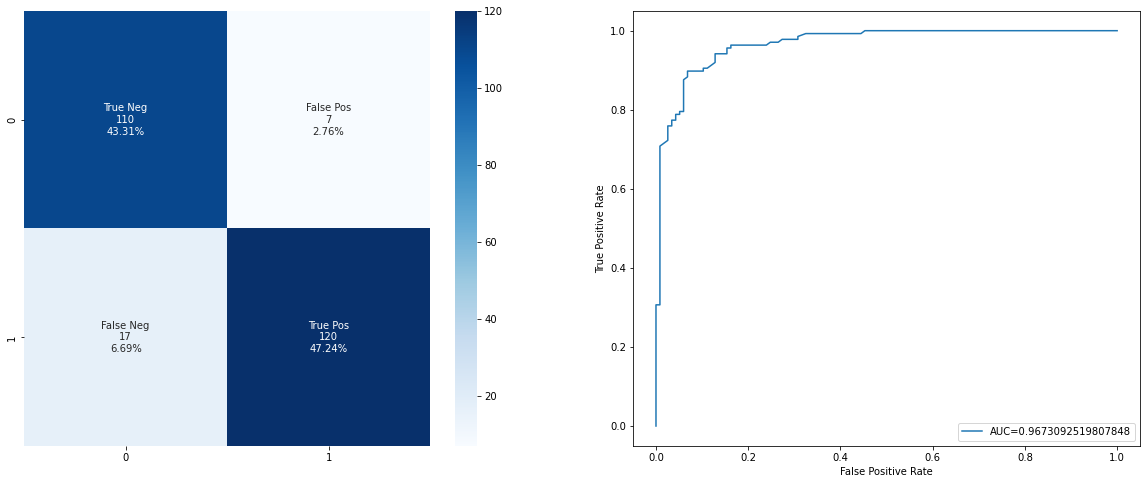

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       117
           1       0.94      0.88      0.91       137

    accuracy                           0.91       254
   macro avg       0.91      0.91      0.91       254
weighted avg       0.91      0.91      0.91       254



In [225]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:1'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

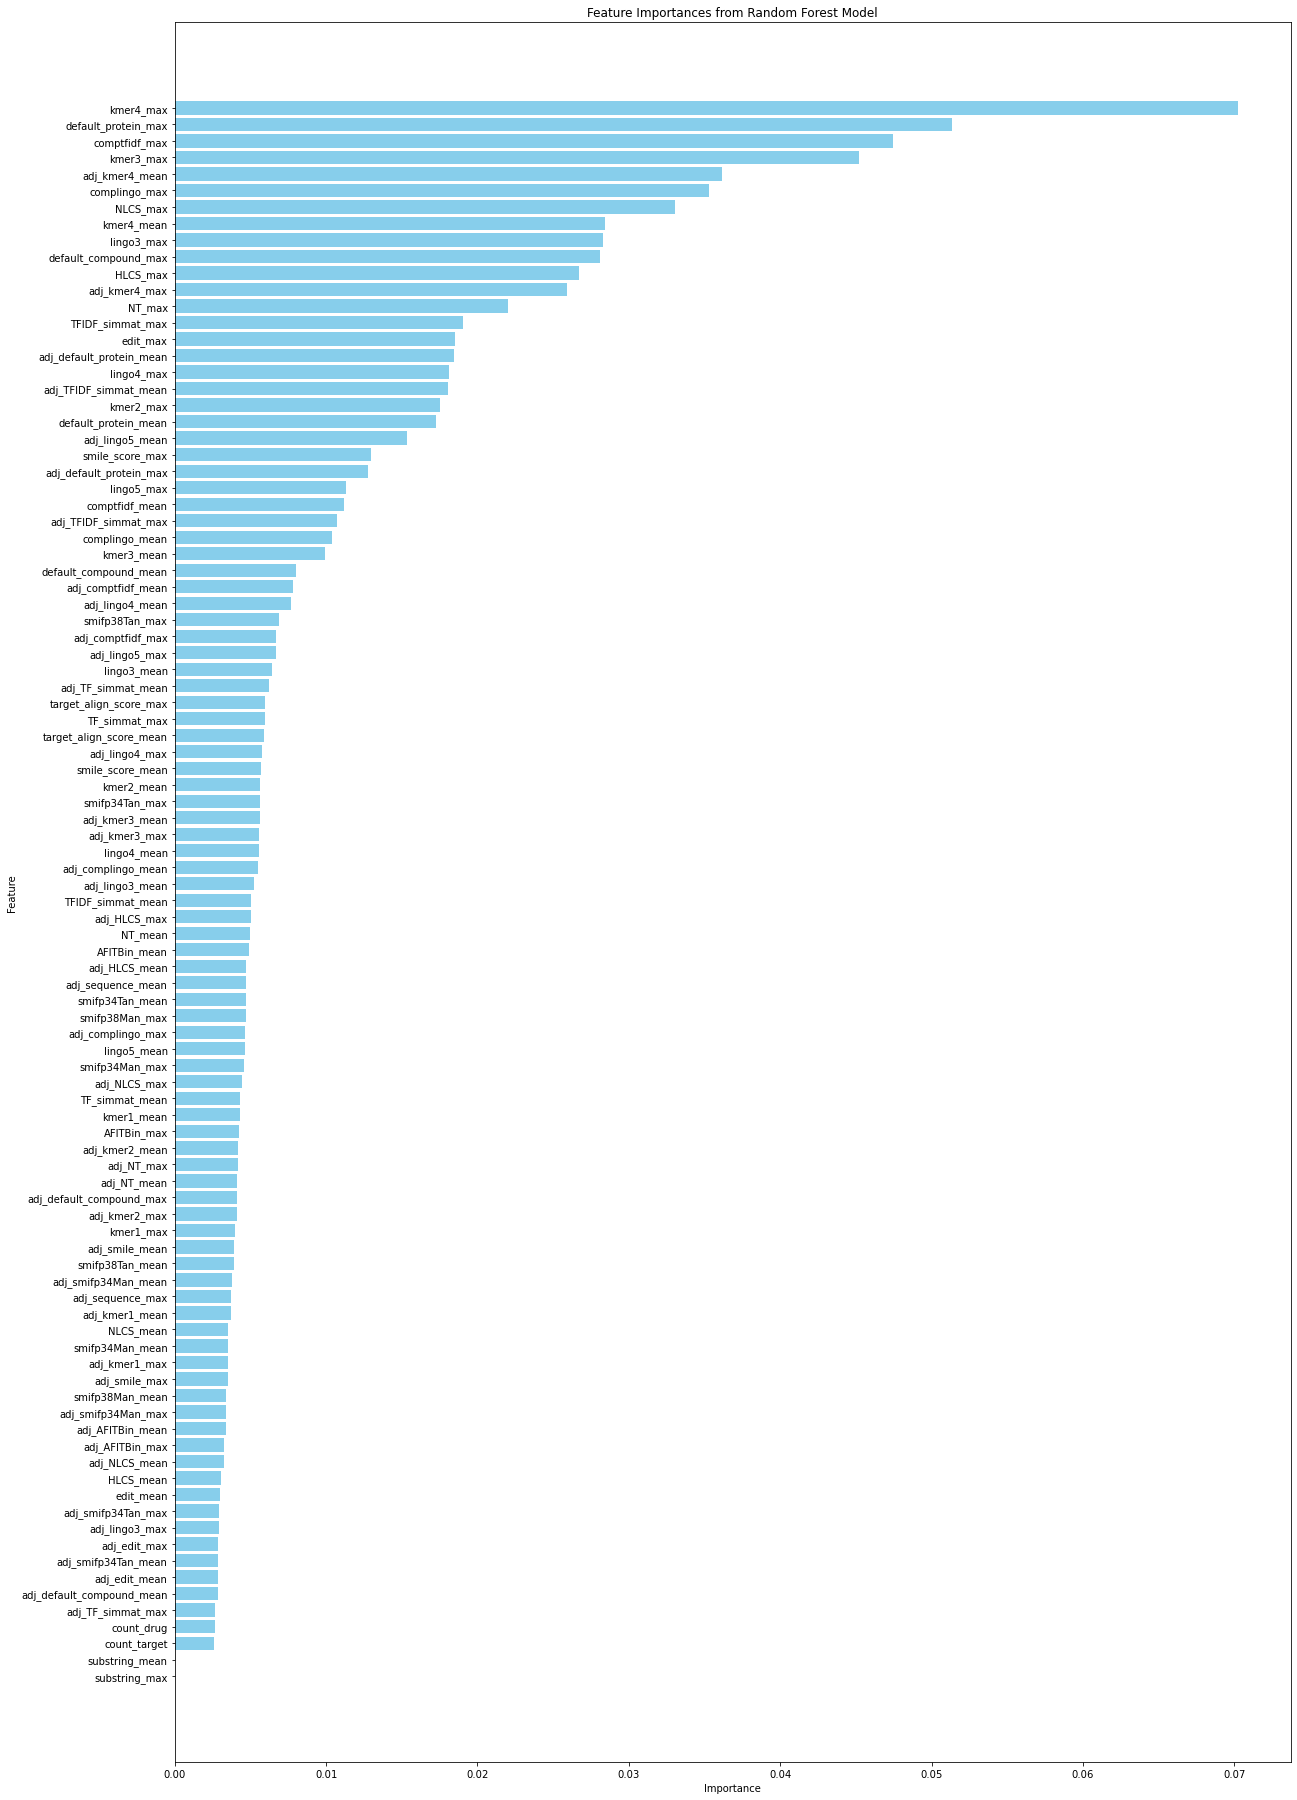

In [226]:
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 32))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# 

<a name="3.1.1"></a>
**Feature Selection**

In [ ]:
Final Accuracy with selected features: 0.937007874015748

In [227]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.8464566929133859
Added feature: adj_smile_mean - Accuracy: 0.8976377952755905
Added feature: adj_kmer3_max - Accuracy: 0.937007874015748
Selected features: ['default_protein_max', 'adj_smile_mean', 'adj_kmer3_max']
Final Accuracy with selected features: 0.937007874015748


Results of  GPCR 1:1 topFeatures

 RandomForest ...................................

Accuracy: 0.937007874015748
F1-Score: 0.9416058394160584
AUPRC: 0.9764103872801793
AUROC: 0.9686193773785016
PrecisionClass0: 0.9316239316239316
RecallClass0: 0.9316239316239316
PrecisionClass1: 0.9416058394160584
RecallClass1: 0.9416058394160584


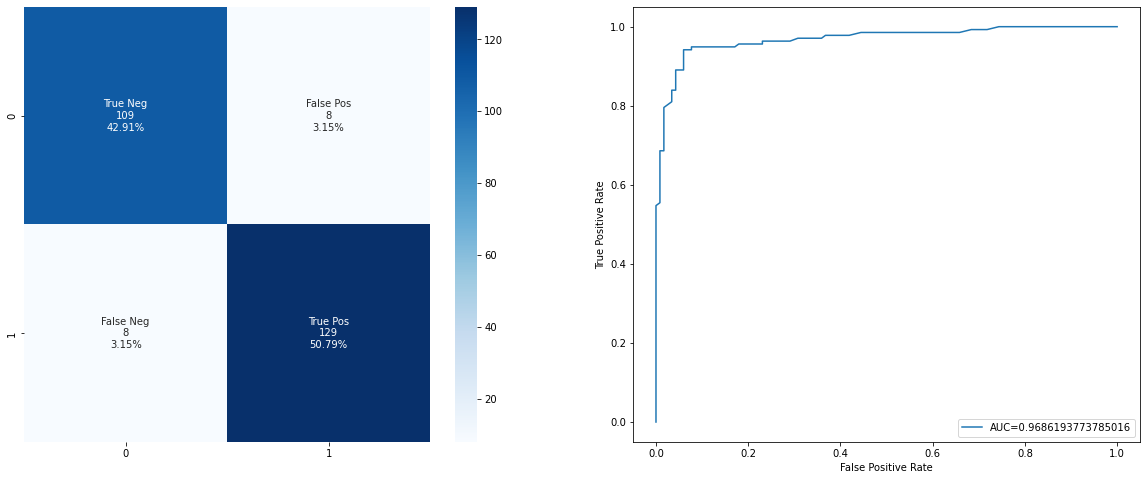

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       117
           1       0.94      0.94      0.94       137

    accuracy                           0.94       254
   macro avg       0.94      0.94      0.94       254
weighted avg       0.94      0.94      0.94       254



In [230]:
top_features = ['default_protein_max', 'adj_smile_mean', 'adj_kmer3_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)

data_name = 'GPCR 1:1 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [288]:
columns = ['Model','AUPRC', 'AUROC', 'Accuracy']
metricTableClassification = pd.DataFrame(columns=columns)
metricTableClassification


,Model,AUPRC,AUROC,Accuracy


In [289]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc
import pandas as pd

Results of KNN

 KNN ...................................

Accuracy: 0.8779527559055118
F1-Score: 0.8847583643122676
AUPRC: 0.9516412612869211
AUROC: 0.950558362967122
PrecisionClass0: 0.8524590163934426
RecallClass0: 0.8888888888888888
PrecisionClass1: 0.9015151515151515
RecallClass1: 0.8686131386861314


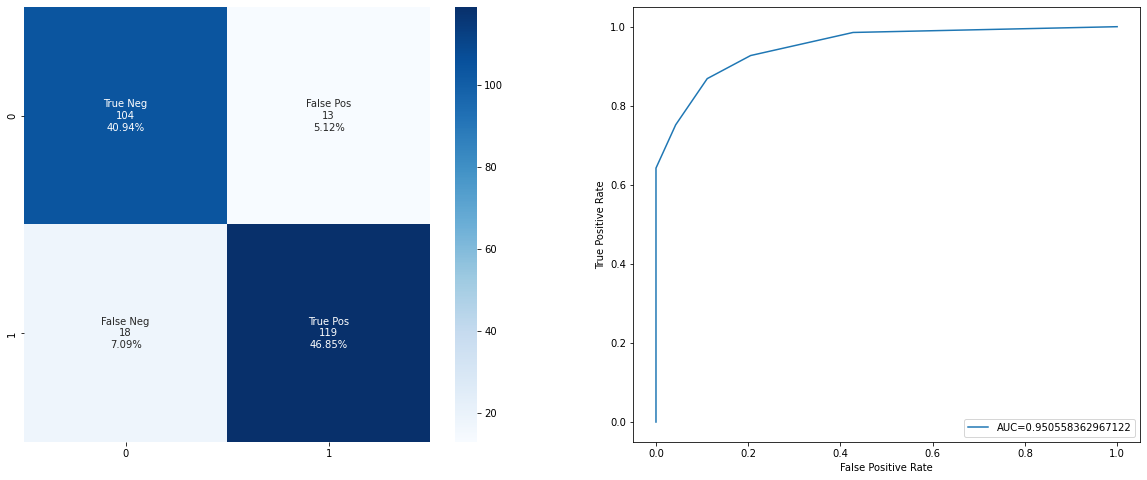

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       117
           1       0.90      0.87      0.88       137

    accuracy                           0.88       254
   macro avg       0.88      0.88      0.88       254
weighted avg       0.88      0.88      0.88       254

Results of Logistic Regression

 Logistic Regression ...................................

Accuracy: 0.84251968503937
F1-Score: 0.8449612403100776
AUPRC: 0.9363444104469238
AUROC: 0.904485619814087
PrecisionClass0: 0.7894736842105263
RecallClass0: 0.8974358974358975
PrecisionClass1: 0.9008264462809917
RecallClass1: 0.7956204379562044


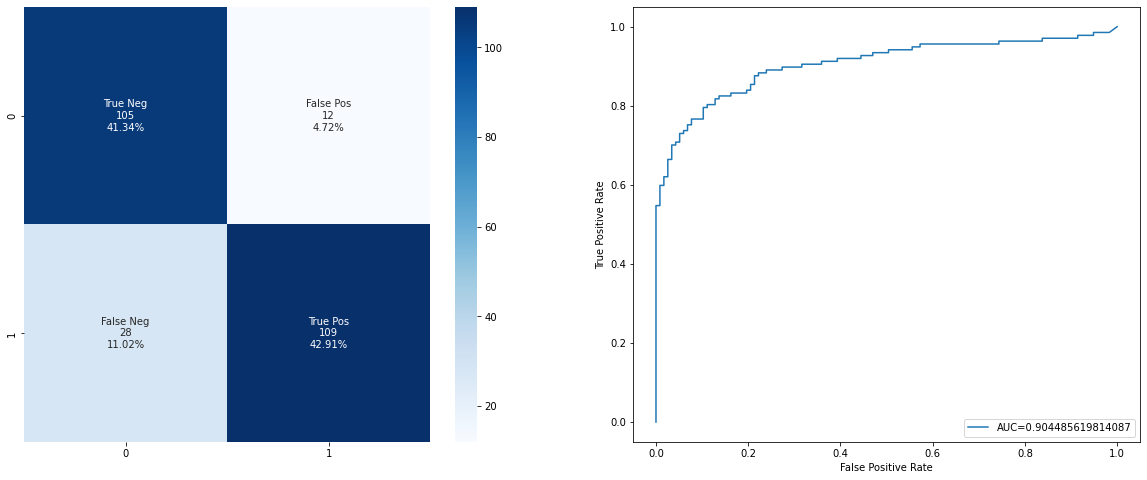

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       117
           1       0.90      0.80      0.84       137

    accuracy                           0.84       254
   macro avg       0.85      0.85      0.84       254
weighted avg       0.85      0.84      0.84       254

Results of MLP Model 1

 MLP Model 1 ...................................

Accuracy: 0.9015748031496063
F1-Score: 0.9077490774907749
AUPRC: 0.9722441501695642
AUROC: 0.9616320419240126
PrecisionClass0: 0.8833333333333333
RecallClass0: 0.905982905982906
PrecisionClass1: 0.917910447761194
RecallClass1: 0.8978102189781022


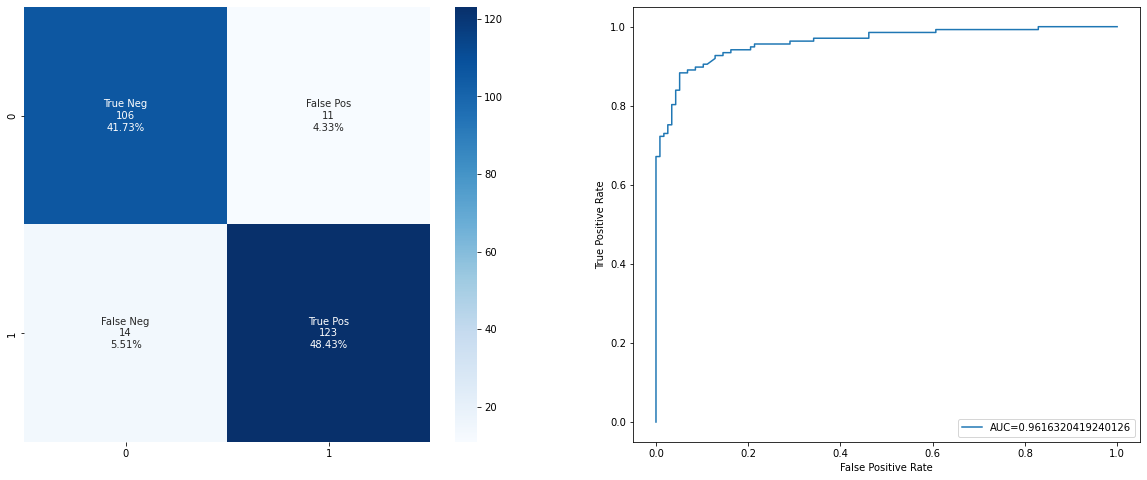

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       117
           1       0.92      0.90      0.91       137

    accuracy                           0.90       254
   macro avg       0.90      0.90      0.90       254
weighted avg       0.90      0.90      0.90       254

Results of MLP Model 2

 MLP Model 2 ...................................

Accuracy: 0.9094488188976378
F1-Score: 0.9144981412639405
AUPRC: 0.9755113819816892
AUROC: 0.966061513506769
PrecisionClass0: 0.8852459016393442
RecallClass0: 0.9230769230769231
PrecisionClass1: 0.9318181818181818
RecallClass1: 0.8978102189781022


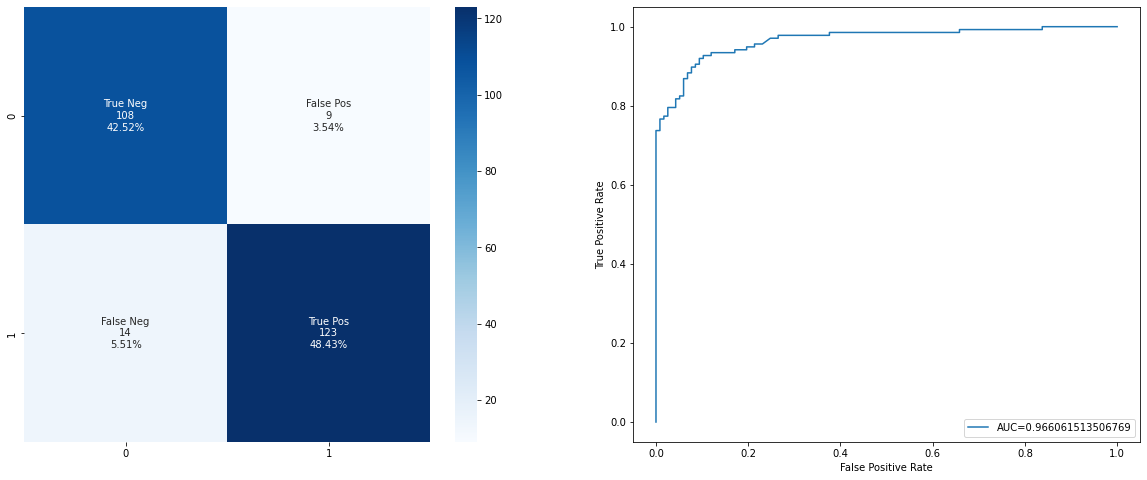

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       117
           1       0.93      0.90      0.91       137

    accuracy                           0.91       254
   macro avg       0.91      0.91      0.91       254
weighted avg       0.91      0.91      0.91       254

Results of Decision Tree

 Decision Tree ...................................

Accuracy: 0.8976377952755905
F1-Score: 0.907142857142857
AUPRC: 0.8728466898253386
AUROC: 0.9020525297897561
PrecisionClass0: 0.9099099099099099
RecallClass0: 0.8632478632478633
PrecisionClass1: 0.8881118881118881
RecallClass1: 0.927007299270073


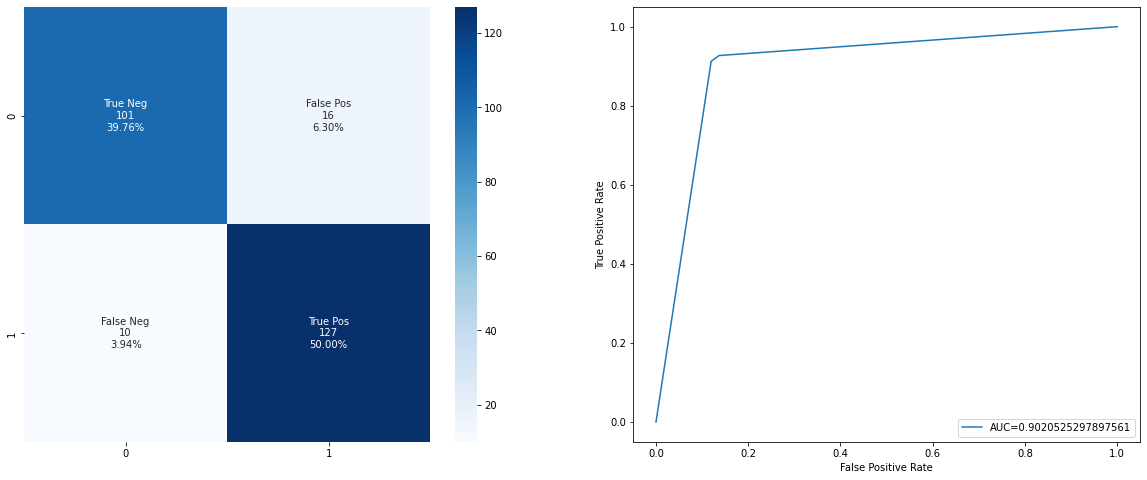

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       117
           1       0.89      0.93      0.91       137

    accuracy                           0.90       254
   macro avg       0.90      0.90      0.90       254
weighted avg       0.90      0.90      0.90       254

Results of Random Forest

 Random Forest ...................................

Accuracy: 0.9330708661417323
F1-Score: 0.9381818181818182
AUPRC: 0.976927196373828
AUROC: 0.9695551812340133
PrecisionClass0: 0.9310344827586207
RecallClass0: 0.9230769230769231
PrecisionClass1: 0.9347826086956522
RecallClass1: 0.9416058394160584


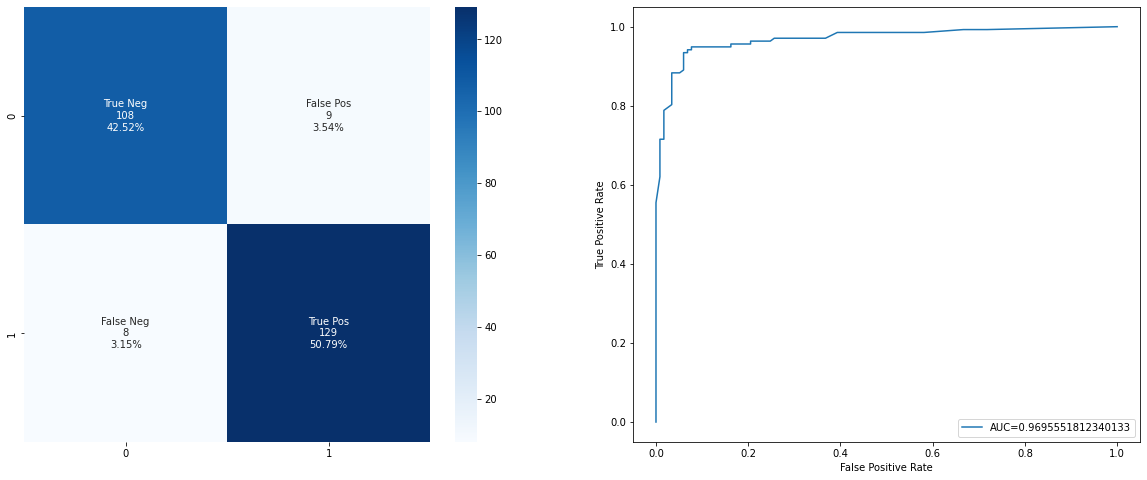

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       117
           1       0.93      0.94      0.94       137

    accuracy                           0.93       254
   macro avg       0.93      0.93      0.93       254
weighted avg       0.93      0.93      0.93       254



,Model,AUPRC,AUROC,Accuracy
0,KNN,0.951641,0.950558,0.877953
1,Logistic Regression,0.936344,0.904486,0.842520
2,MLP Model 1,0.972244,0.961632,0.901575
3,MLP Model 2,0.975511,0.966062,0.909449
4,Decision Tree,0.872847,0.902053,0.897638
5,Random Forest,0.976927,0.969555,0.933071


In [290]:
top_features = ['default_protein_max', 'adj_smile_mean', 'adj_kmer3_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)

# List of models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Model 1': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP Model 2': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}




for model_name, model in models.items():
    print(f"Results of {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auprc, auc_score, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, tp = confusionMat_v2(y_test, y_pred, y_prob,model_name)
    
    # Save results
    df_list = [model_name, auprc, auc_score, accuracy]
    metricTableClassification.loc[len(metricTableClassification)] = df_list

metricTableClassification

# 

<a name="3.2"></a>
### Ratio 1:5
- [Evaluatuin](#3.2.0)
- [Feature Selection](#3.2.1)

In [260]:
# Generate a DataFrame with 635 random combinations
num_combinations = len(mapping) * 5
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa338442,D00049,1
1,1,hsa1812,D00059,1
2,2,hsa1813,D00059,1
3,3,hsa5739,D00079,1
4,4,hsa9052,D00094,1
...,...,...,...,...
3805,3805,hsa151,D00726,0
3806,3806,hsa2917,D03274,0
3807,3807,hsa3350,D02910,0
3808,3808,hsa2913,D01242,0


In [261]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [262]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #AFITBIN 
                                  "AFITBin_max" , "AFITBin_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0
    AFITBin_max = 0 
    
    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    AFITBin_mean = 0 
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                               
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max  = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #AFITBIN
        AFITBin_max = max(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        AFITBin_mean = mean(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #AFITBIN 
                    AFITBin_max , AFITBin_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_AFITBin_max']           = df_scores['count_drug'] * df_scores['AFITBin_max']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_AFITBin_mean']           = df_scores['count_drug'] * df_scores['AFITBin_mean']


df_scores

3810it [06:14, 10.18it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TF_simmat_mean,adj_complingo_mean,adj_comptfidf_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,adj_AFITBin_mean
0,0,D00049,hsa338442,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00059,hsa1812,0.185185,0.111484,0.08683,0.062212,0.2188,0.166572,0.19775,...,1.90955,1.555511,1.384297,3.464321,1.319568,0.77245,0.418183,0.54809,5.44993,12.780269
2,2,D00059,hsa1813,0.132743,0.10667,0.06893,0.058713,0.18963,0.158152,0.15276,...,2.37078,1.803807,1.623992,3.945506,1.522063,0.88977,0.439013,0.5778,6.40524,15.729562
3,3,D00079,hsa5739,0.703704,0.536972,0.72185,0.47586,0.95,0.80591,0.81618,...,2.47229,2.00233,2.084135,2.437796,2.069944,1.95021,1.835735,0.67143,2.45098,0
4,4,D00094,hsa9052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,3805,D00726,hsa151,0.229167,0.117114,0.15692,0.099298,0.4313,0.266605,0.17925,...,3.84448,3.450781,3.241595,8.385784,4.070965,1.93329,0.923662,1.40777,12.89921,23.030373
3806,3806,D03274,hsa2917,0.117021,0.117021,0.06238,0.06238,0.16516,0.16516,0.02761,...,0.20076,0.113512,0.100762,0.241935,0.095111,0.05311,0.032292,0.02439,0.30708,0.905876
3807,3807,D02910,hsa3350,0.258929,0.184627,0.14748,0.100135,0.32527,0.266708,0.15846,...,1.61482,1.386666,1.145746,1.909985,1.493241,0.82013,0.569711,0.36255,3.19819,5.691866
3808,3808,D01242,hsa2913,0.097561,0.056655,0.05522,0.04369,0.15,0.121375,0.01337,...,0.10389,0.114226,0.104246,0.383333,0.091698,0.03333,0.009259,0.05481,0.83082,1.993021


In [263]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean',
       'default_protein_max', 'default_protein_mean', 'default_compound_max',
       'default_compound_mean', 'AFITBin_max', 'AFITBin_mean', 'count_drug',
       'count_target', 'adj_smile_max', 'adj_sequence_max',
       'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max', 'adj_kmer4_max',
       'adj_NT_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_comptfidf_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_AFITBin_max',
       'adj_smile_mean', 'adj_sequence_mean', 'adj_kmer1_mean',
       'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_comptfidf_mean',
       'adj_edit_mean', 'adj_lingo3_mean', 'adj_lingo4_mean',
       'adj_lingo5_mean', 'adj_smifp34Man_mean', 'adj_smifp34Tan_mean',
       'adj_AFITBin_mean']

Results of  GPCR 1:5

 RandomForest ...................................

Accuracy: 0.9540682414698163
F1-Score: 0.8727272727272726
AUPRC: 0.9390321418582394
AUROC: 0.9709070894858566
PrecisionClass0: 0.9589257503949447
RecallClass0: 0.9853896103896104
PrecisionClass1: 0.9302325581395349
RecallClass1: 0.821917808219178


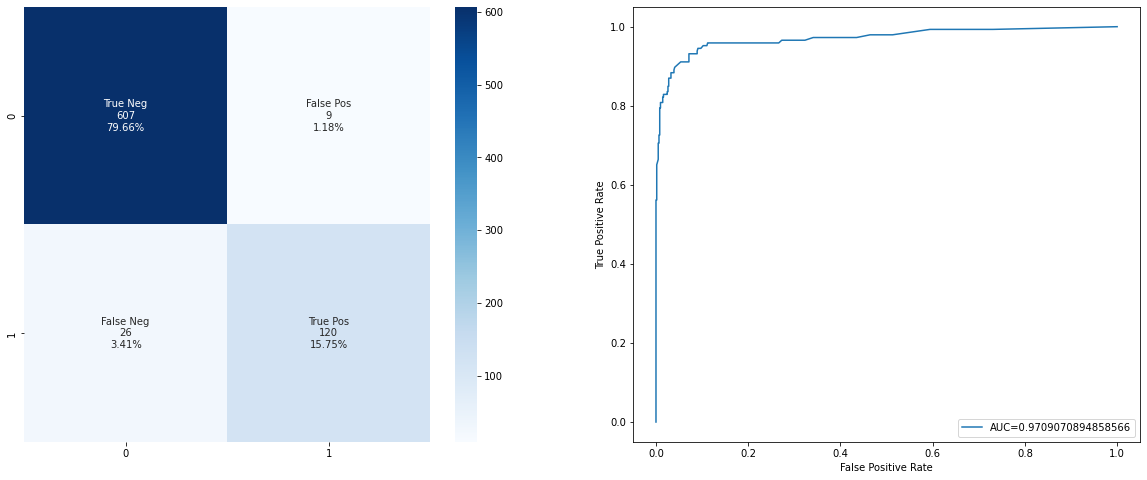

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       616
           1       0.93      0.82      0.87       146

    accuracy                           0.95       762
   macro avg       0.94      0.90      0.92       762
weighted avg       0.95      0.95      0.95       762



In [269]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [237]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.9120734908136483
Added feature: TF_simmat_mean - Accuracy: 0.9383202099737533
Added feature: TFIDF_simmat_max - Accuracy: 0.9488188976377953
Added feature: adj_HLCS_mean - Accuracy: 0.9501312335958005
Added feature: adj_kmer3_max - Accuracy: 0.9566929133858267
Added feature: kmer2_mean - Accuracy: 0.958005249343832
Selected features: ['default_protein_max', 'TF_simmat_mean', 'TFIDF_simmat_max', 'adj_HLCS_mean', 'adj_kmer3_max', 'kmer2_mean']
Final Accuracy with selected features: 0.958005249343832


Results of  GPCR 1:5 topFeatures

 RandomForest ...................................

Accuracy: 0.958005249343832
F1-Score: 0.8848920863309353
AUPRC: 0.9204665187823236
AUROC: 0.9660647571606475
PrecisionClass0: 0.9634920634920635
RecallClass0: 0.9853896103896104
PrecisionClass1: 0.9318181818181818
RecallClass1: 0.8424657534246576


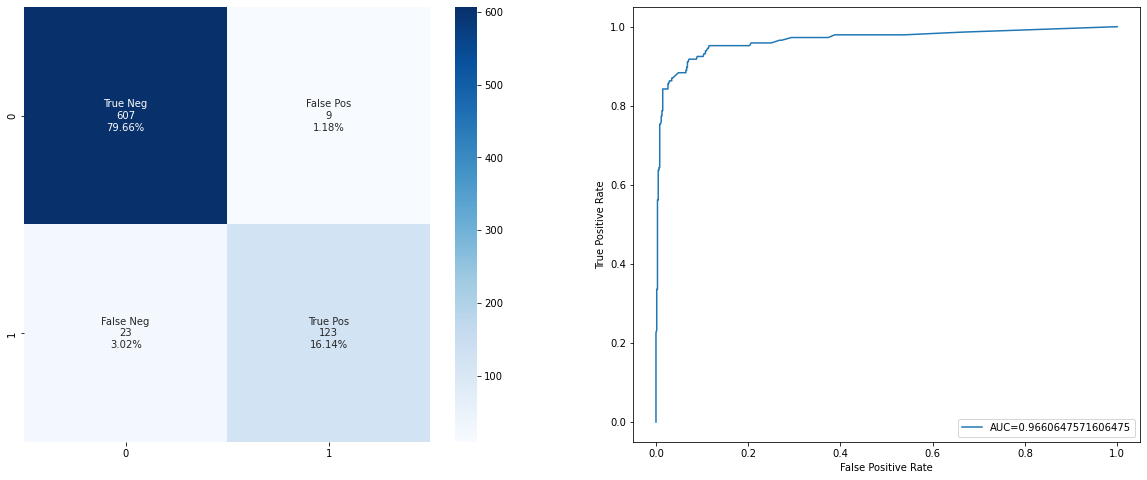

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       616
           1       0.93      0.84      0.88       146

    accuracy                           0.96       762
   macro avg       0.95      0.91      0.93       762
weighted avg       0.96      0.96      0.96       762



In [267]:
topFeatures = ['default_protein_max', 'TF_simmat_mean', 'TFIDF_simmat_max', 'adj_HLCS_mean', 'adj_kmer3_max', 'kmer2_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:5 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [275]:
from sklearn.metrics import precision_recall_curve, auc


In [277]:
selected_features = []
best_aupr = 0  # Start with zero as the best AUPR

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred_proba = rf.predict_proba(X_test[temp_features])[:, 1]

        # Calculate precision-recall curve and AUPR
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)        
        current_aupr = auc(recall, precision)

        # If this model is better, select this feature
        if current_aupr > best_aupr:
            best_aupr = current_aupr
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - AUPR: {best_aupr}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final_proba = rf_final.predict_proba(X_test[selected_features])[:, 1]

# Calculate final precision-recall curve and AUPR
precision_final, recall_final, _ = precision_recall_curve(y_test, y_pred_final_proba)
final_aupr = auc(recall_final, precision_final)
print(f"Final AUPR with selected features: {final_aupr}")

Added feature: default_protein_max - AUPR: 0.8292863957907807
Added feature: default_compound_max - AUPR: 0.8872361477062686
Added feature: adj_kmer4_mean - AUPR: 0.9091375499065083
Added feature: adj_default_compound_mean - AUPR: 0.9298418671381946
Added feature: lingo4_mean - AUPR: 0.9431075750126707
Added feature: adj_kmer2_max - AUPR: 0.9469815142413036
Selected features: ['default_protein_max', 'default_compound_max', 'adj_kmer4_mean', 'adj_default_compound_mean', 'lingo4_mean', 'adj_kmer2_max']
Final AUPR with selected features: 0.9469815142413036


Results of  GPCR 1:5 topFeatures

 RandomForest ...................................

Accuracy: 0.9514435695538058
F1-Score: 0.8644688644688645
AUPRC: 0.9461170928242921
AUROC: 0.9775562622309197
PrecisionClass0: 0.9559055118110236
RecallClass0: 0.9853896103896104
PrecisionClass1: 0.9291338582677166
RecallClass1: 0.8082191780821918


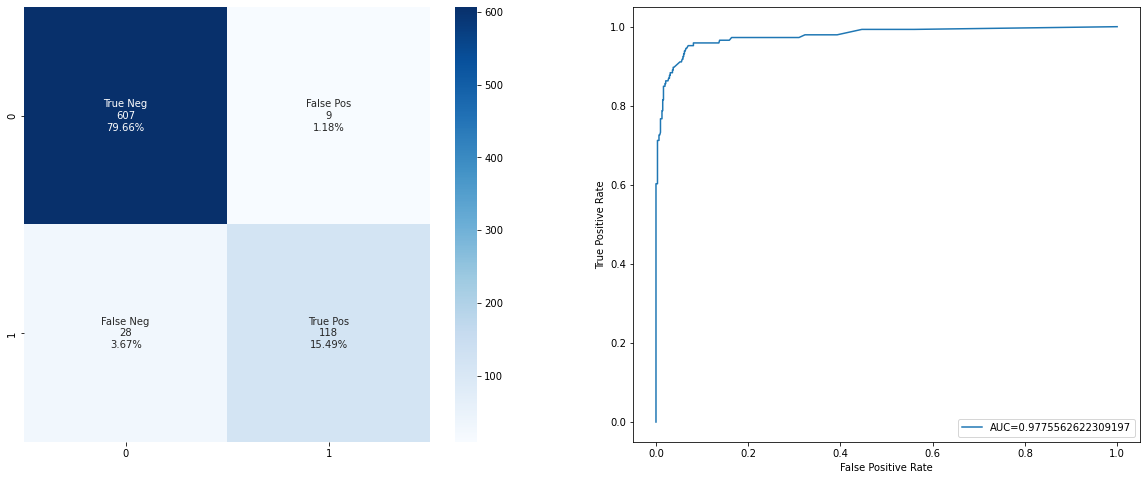

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       616
           1       0.93      0.81      0.86       146

    accuracy                           0.95       762
   macro avg       0.94      0.90      0.92       762
weighted avg       0.95      0.95      0.95       762



In [278]:
topFeatures = ['default_protein_max', 'default_compound_max', 
               'adj_kmer4_mean', 'adj_default_compound_mean',
               'lingo4_mean', 'adj_kmer2_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:5 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

# 

<a name="3.3"></a>
### Ratio 1:10
- [Evaluatuin](#3.3.0)
- [Feature Selection](#3.3.1)

In [251]:
# Generate a DataFrame with 635 random combinations
num_combinations = len(mapping) * 10
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all


,index,Protein,Drug,Label
0,0,hsa338442,D00049,1
1,1,hsa1812,D00059,1
2,2,hsa1813,D00059,1
3,3,hsa5739,D00079,1
4,4,hsa9052,D00094,1
...,...,...,...,...
6980,6980,hsa9052,D00635,0
6981,6981,hsa1268,D00241,0
6982,6982,hsa9934,D01712,0
6983,6983,hsa6010,D02884,0


In [252]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [253]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #AFITBIN 
                                  "AFITBin_max" , "AFITBin_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0
    AFITBin_max = 0 
    
    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    AFITBin_mean = 0 
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                               
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max  = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #AFITBIN
        AFITBin_max = max(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        AFITBin_mean = mean(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #AFITBIN 
                    AFITBin_max , AFITBin_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_AFITBin_max']           = df_scores['count_drug'] * df_scores['AFITBin_max']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_AFITBin_mean']           = df_scores['count_drug'] * df_scores['AFITBin_mean']


df_scores

6985it [05:23, 21.60it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TF_simmat_mean,adj_complingo_mean,adj_comptfidf_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,adj_AFITBin_mean
0,0,D00049,hsa338442,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00059,hsa1812,0.185185,0.108521,0.08683,0.062766,0.2188,0.167674,0.19775,...,1.66817,1.30767,1.170395,2.910614,1.173965,0.68439,0.376386,0.46343,4.72846,10.814074
2,2,D00059,hsa1813,0.132743,0.104003,0.06893,0.058144,0.18963,0.157597,0.15276,...,2.26796,1.79761,1.614414,3.912949,1.479948,0.84991,0.435659,0.57185,6.29247,15.729562
3,3,D00079,hsa5739,0.703704,0.536972,0.72185,0.47586,0.95,0.80591,0.81618,...,2.47229,2.00233,2.084135,2.437796,2.069944,1.95021,1.835735,0.67143,2.45098,0
4,4,D00094,hsa9052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,6980,D00635,hsa9052,0.075581,0.075581,0.08235,0.08235,0.2383,0.2383,0.05351,...,0.17738,0.107746,0.093422,0.328571,0.133333,0.08216,0.04329,0.0303,0.46023,0.938632
6981,6981,D00241,hsa1268,0.085106,0.085106,0.06472,0.06472,0.18131,0.18131,0.01092,...,0.06838,0.114014,0.102234,0.276596,0.131944,0.03448,0.0,0.05,0.47984,0
6982,6982,D01712,hsa9934,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
6983,6983,D02884,hsa6010,0.042105,0.042105,0.04799,0.04799,0.1287,0.1287,0.0,...,0.0,0.028571,0.028571,0.27027,0.025641,0.0,0.0,0.03333,0.21928,0.993776


In [254]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean',
       'default_protein_max', 'default_protein_mean', 'default_compound_max',
       'default_compound_mean', 'AFITBin_max', 'AFITBin_mean', 'count_drug',
       'count_target', 'adj_smile_max', 'adj_sequence_max',
       'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max', 'adj_kmer4_max',
       'adj_NT_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_comptfidf_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_AFITBin_max',
       'adj_smile_mean', 'adj_sequence_mean', 'adj_kmer1_mean',
       'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_comptfidf_mean',
       'adj_edit_mean', 'adj_lingo3_mean', 'adj_lingo4_mean',
       'adj_lingo5_mean', 'adj_smifp34Man_mean', 'adj_smifp34Tan_mean',]

Results of  GPCR 1:10

 RandomForest ...................................

Accuracy: 0.9577666428060129
F1-Score: 0.7722007722007722
AUPRC: 0.8444523845791447
AUROC: 0.9382630881596092
PrecisionClass0: 0.9641744548286605
RecallClass0: 0.9896083133493205
PrecisionClass1: 0.8849557522123894
RecallClass1: 0.684931506849315


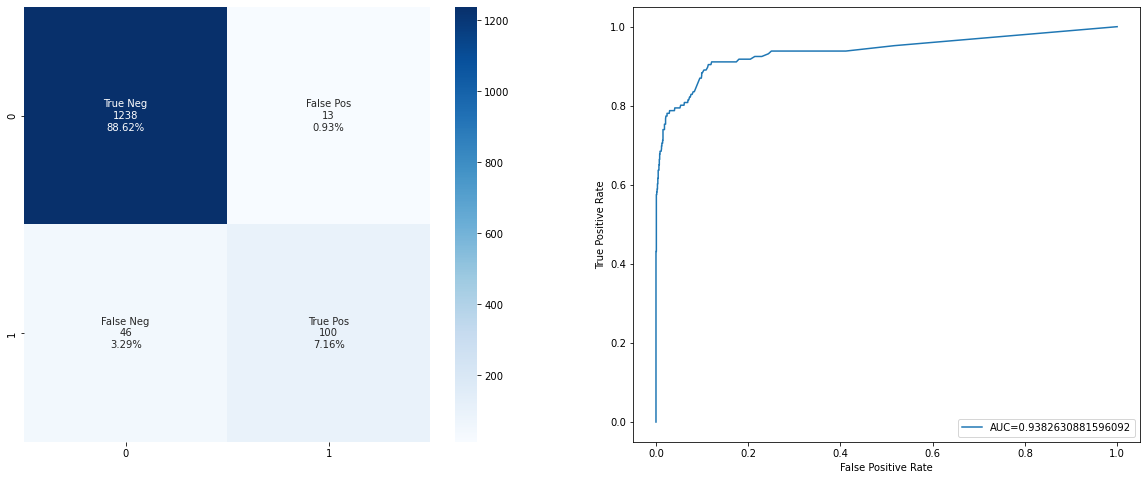

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1251
           1       0.88      0.68      0.77       146

    accuracy                           0.96      1397
   macro avg       0.92      0.84      0.87      1397
weighted avg       0.96      0.96      0.96      1397



In [255]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:10'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

**Feature Selection** 

In [247]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.9420186113099499
Added feature: adj_kmer3_mean - Accuracy: 0.9491768074445239
Added feature: comptfidf_max - Accuracy: 0.9534717251252685
Added feature: comptfidf_mean - Accuracy: 0.9606299212598425
Added feature: adj_default_compound_mean - Accuracy: 0.9627773801002147
Added feature: adj_NT_mean - Accuracy: 0.9656406585540444
Selected features: ['default_protein_max', 'adj_kmer3_mean', 'comptfidf_max', 'comptfidf_mean', 'adj_default_compound_mean', 'adj_NT_mean']
Final Accuracy with selected features: 0.9656406585540444


Results of  GPCR 1:10 topFeatures

 RandomForest ...................................

Accuracy: 0.9656406585540444
F1-Score: 0.818181818181818
AUPRC: 0.8482832500332121
AUROC: 0.9439982260766728
PrecisionClass0: 0.9702892885066459
RecallClass0: 0.9920063948840927
PrecisionClass1: 0.9152542372881356
RecallClass1: 0.7397260273972602


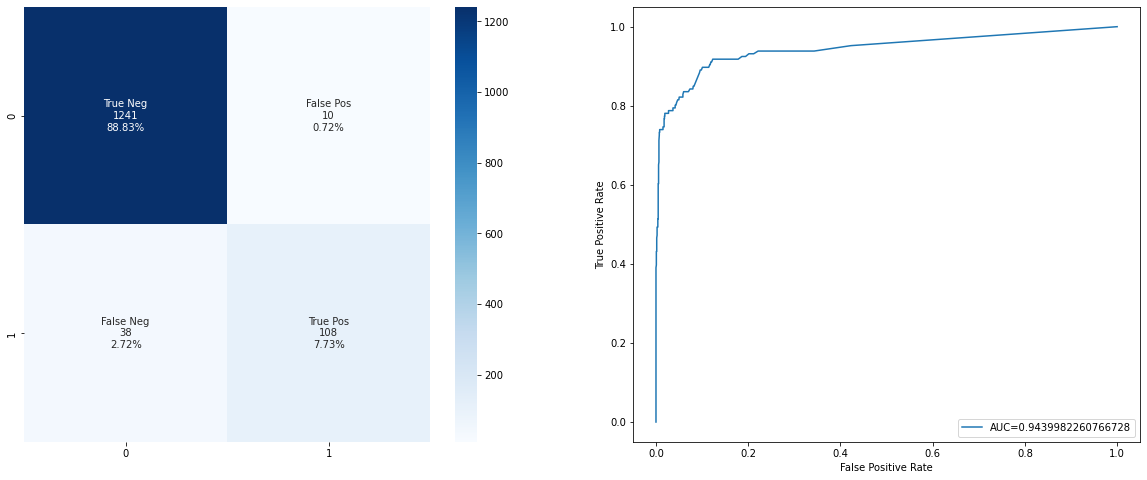

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1251
           1       0.92      0.74      0.82       146

    accuracy                           0.97      1397
   macro avg       0.94      0.87      0.90      1397
weighted avg       0.96      0.97      0.96      1397



In [248]:
topFeatures = ['default_protein_max',
               'adj_kmer3_mean', 'comptfidf_max', 'comptfidf_mean', 'adj_default_compound_mean', 'adj_NT_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:10 topFeatures'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [250]:
metricTable[["Data","AUPRC","AUROC","Accuracy"]]

,Data,AUPRC,AUROC,Accuracy
0,GPCR 1:1,0.970107,0.967309,0.905512
1,GPCR 1:1 topFeatures,0.976410,0.968619,0.937008
2,GPCR 1:5,0.939032,0.970907,0.954068
3,GPCR 1:5 topFeatures,0.920467,0.966065,0.958005
4,GPCR 1:10,0.844452,0.938263,0.957767
5,GPCR 1:10 topFeatures,0.848283,0.943998,0.965641


In [257]:
from sklearn.metrics import precision_recall_curve, auc


In [258]:
selected_features = []
best_aupr = 0  # Start with zero as the best AUPR

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred_proba = rf.predict_proba(X_test[temp_features])[:, 1]

        # Calculate precision-recall curve and AUPR
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        current_aupr = auc(recall, precision)

        # If this model is better, select this feature
        if current_aupr > best_aupr:
            best_aupr = current_aupr
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - AUPR: {best_aupr}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final_proba = rf_final.predict_proba(X_test[selected_features])[:, 1]

# Calculate final precision-recall curve and AUPR
precision_final, recall_final, _ = precision_recall_curve(y_test, y_pred_final_proba)
final_aupr = auc(recall_final, precision_final)
print(f"Final AUPR with selected features: {final_aupr}")

Added feature: default_protein_max - AUPR: 0.6973678406887382
Added feature: adj_sequence_max - AUPR: 0.7784732986769383
Added feature: complingo_max - AUPR: 0.8225605281556035
Added feature: default_compound_mean - AUPR: 0.8387821596084053
Added feature: adj_AFITBin_max - AUPR: 0.8536996686398646
Added feature: kmer2_max - AUPR: 0.8584354110636117
Added feature: count_target - AUPR: 0.8614719868803745
Added feature: target_align_score_max - AUPR: 0.8631339949664855
Selected features: ['default_protein_max', 'adj_sequence_max', 'complingo_max', 'default_compound_mean', 'adj_AFITBin_max', 'kmer2_max', 'count_target', 'target_align_score_max']
Final AUPR with selected features: 0.8631339949664855


Results of  GPCR 1:10 topFeatures2

 RandomForest ...................................

Accuracy: 0.9570508231925555
F1-Score: 0.7709923664122137
AUPRC: 0.8596055511729999
AUROC: 0.9452657052440239
PrecisionClass0: 0.9648711943793911
RecallClass0: 0.988009592326139
PrecisionClass1: 0.8706896551724138
RecallClass1: 0.6917808219178082


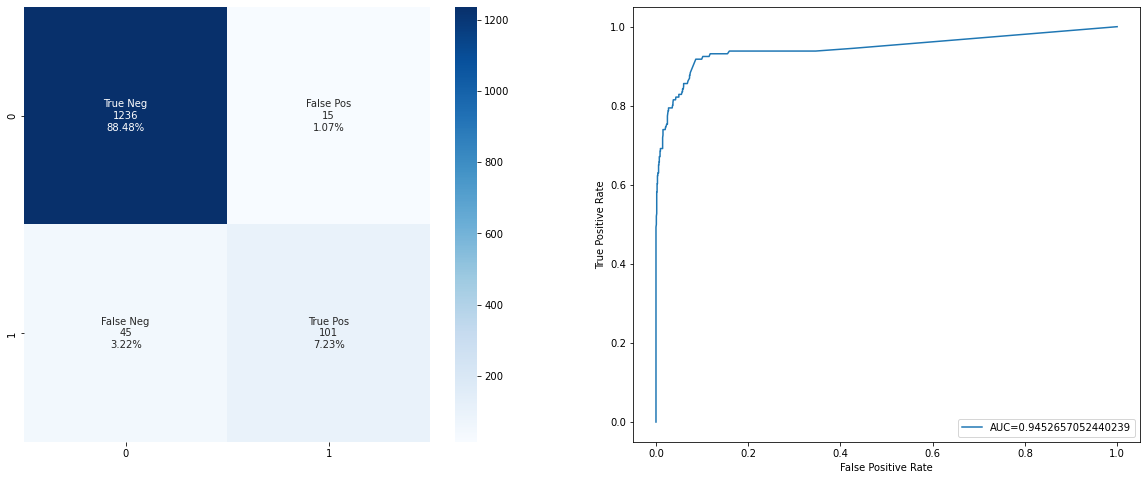

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1251
           1       0.87      0.69      0.77       146

    accuracy                           0.96      1397
   macro avg       0.92      0.84      0.87      1397
weighted avg       0.96      0.96      0.95      1397



In [259]:
topFeatures = ['default_protein_max', 
               'adj_sequence_max', 'complingo_max', 'default_compound_mean', 'adj_AFITBin_max', 'kmer2_max', 'count_target', 'target_align_score_max']
# Split into X_train, y_train, X_test, y_test
X_train = train[topFeatures]
y_train = train['target']
X_test = test[topFeatures]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'GPCR 1:10 topFeatures2'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [ ]:
features_GPCR_10 = ['default_protein_max',
               'adj_kmer3_mean', 'comptfidf_max', 'comptfidf_mean', 'adj_default_compound_mean', 'adj_NT_mean']

features_GPCR_5 = ['default_protein_max', 'default_compound_max', 
               'adj_kmer4_mean', 'adj_default_compound_mean',
               'lingo4_mean', 'adj_kmer2_max']

features_GPCR_1 = ['default_protein_max', 'adj_smile_mean', 'adj_kmer3_max']

## Case Study

In [291]:
mapping

,Protein,Drug
0,hsa338442,D00049
1,hsa1812,D00059
2,hsa1813,D00059
3,hsa5739,D00079
4,hsa9052,D00094
...,...,...
630,hsa3352,D05740
631,hsa154,D05792
632,hsa4988,D05938
633,hsa3360,D06056


In [292]:
from itertools import product
# Extract unique proteins and drugs
unique_proteins = mapping['Protein'].unique()
unique_drugs = mapping['Drug'].unique()

# Generate all possible combinations
all_combinations = list(product(unique_proteins, unique_drugs))

# Check if each combination is in the original DataFrame
combination_labels = [
    (protein, drug, 1 if not mapping[(mapping['Protein'] == protein) & (mapping['Drug'] == drug)].empty else 0)
    for protein, drug in all_combinations
]

# Create the new DataFrame
new_df = pd.DataFrame(combination_labels, columns=['Protein', 'Drug', 'Label'])
new_df

,Protein,Drug,Label
0,hsa338442,D00049,1
1,hsa338442,D00059,0
2,hsa338442,D00079,0
3,hsa338442,D00094,0
4,hsa338442,D00095,0
...,...,...,...
21180,hsa6010,D05740,0
21181,hsa6010,D05792,0
21182,hsa6010,D05938,0
21183,hsa6010,D06056,0


In [293]:
new_df['Label'].value_counts()

0    20550
1      635
Name: Label, dtype: int64

In [294]:
new_df = new_df.reset_index()

In [295]:
unknown  = new_df[new_df['Label'] == 0]
positive = new_df[new_df['Label'] == 1]
#Negative
negative_df = unknown.sample(n=635 , replace=True, random_state=1)
concatenated_df = pd.concat([positive, negative_df], ignore_index=True)
#Split Dataset
train_mapping, test_mapping = train_test_split(concatenated_df, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [296]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #NT
                                  "NT_max","NT_mean",
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #AFITBIN 
                                  "AFITBin_max" , "AFITBin_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0
    AFITBin_max = 0 
    
    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    AFITBin_mean = 0 
    


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_sim_compound[default_sim_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                               
    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #NT
        NT_max  = max(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        NT_mean = mean(nt_similarity[nt_similarity['KEGG ID'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_sim_protein[default_sim_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #AFITBIN
        AFITBin_max = max(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        AFITBin_mean = mean(AFITBin[AFITBin['Unnamed 0'] == target_test][target_list_one].values.flatten())
        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #NT
                    NT_max, NT_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #AFITBIN 
                    AFITBin_max , AFITBin_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_NT_max']        = df_scores['count_target'] * df_scores['NT_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_AFITBin_max']           = df_scores['count_drug'] * df_scores['AFITBin_max']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_NT_mean']        = df_scores['count_target'] * df_scores['NT_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']

df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_AFITBin_mean']           = df_scores['count_drug'] * df_scores['AFITBin_mean']


df_scores

1270it [01:54, 11.14it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TF_simmat_mean,adj_complingo_mean,adj_comptfidf_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,adj_AFITBin_mean
0,0,D00049,hsa338442,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00059,hsa1812,0.185185,0.111196,0.08683,0.063055,0.2188,0.168687,0.19775,...,1.78169,1.428728,1.278113,3.229027,1.260148,0.72578,0.386132,0.50047,4.99538,11.797171
2,2,D00059,hsa1813,0.155556,0.112666,0.08587,0.061741,0.24194,0.168288,0.15276,...,2.48519,2.104085,1.867185,4.720448,1.680309,0.96216,0.479397,0.72347,7.1008,17.695757
3,3,D00079,hsa5739,0.703704,0.536972,0.72185,0.47586,0.95,0.80591,0.81618,...,2.47229,2.00233,2.084135,2.437796,2.069944,1.95021,1.835735,0.67143,2.45098,0
4,4,D00094,hsa9052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,1265,D00274,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1266,1266,D00606,hsa5731,0.12069,0.063494,0.06746,0.041013,0.17364,0.110247,0.06224,...,0.26031,0.201074,0.179768,0.725522,0.209735,0.11109,0.075166,0.0899,1.40531,3.926257
1267,1267,D01699,hsa23620,0.255172,0.255172,0.10615,0.10615,0.30172,0.30172,0.1009,...,0.34037,0.265715,0.24194,0.342857,0.216816,0.14845,0.104467,0.04545,0.56593,0.931201
1268,1268,D00503,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [297]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

Results of  NuclearReceptor 1:5

 RandomForest ...................................

Accuracy: 0.9473684210526315
F1-Score: 0.9333333333333333
AUPRC: 0.9464285714285714
AUROC: 0.9375
PrecisionClass0: 0.9166666666666666
RecallClass0: 1.0
PrecisionClass1: 1.0
RecallClass1: 0.875


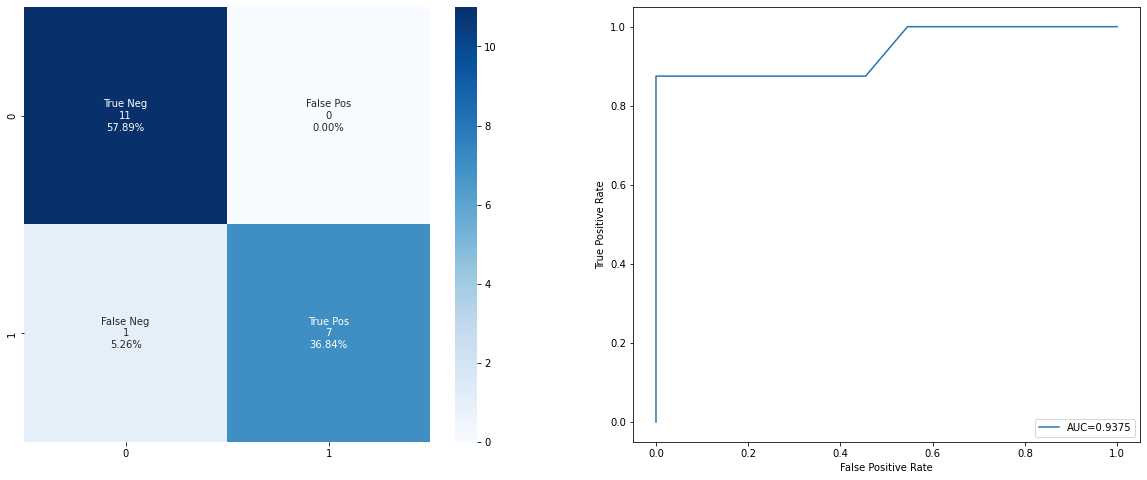

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19



In [298]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'NT_max', 'NT_mean',
       'default_protein_max', 'default_protein_mean', 'default_compound_max',
       'default_compound_mean', 'AFITBin_max', 'AFITBin_mean', 'count_drug',
       'count_target', 'adj_smile_max', 'adj_sequence_max',
       'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max', 'adj_kmer4_max',
       'adj_NT_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_comptfidf_max',
       'adj_edit_max', 'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_AFITBin_max',
       'adj_smile_mean', 'adj_sequence_mean', 'adj_kmer1_mean',
       'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean', 'adj_NT_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_comptfidf_mean',
       'adj_edit_mean', 'adj_lingo3_mean', 'adj_lingo4_mean',
       'adj_lingo5_mean', 'adj_smifp34Man_mean', 'adj_smifp34Tan_mean',]

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [304]:
y_prob

array([0.082, 0.91 , 0.658, 0.75 , 0.824, 0.996, 0.654, 0.972, 0.012,
       0.048, 0.016, 0.05 , 0.2  , 0.266, 0.082, 0.03 , 0.114, 0.396,
       0.238])

In [305]:
unknown_df =  df_scores[df_scores['index'].isin(unknown['index'].tolist())]
unknown_df

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_TF_simmat_mean,adj_complingo_mean,adj_comptfidf_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean,adj_AFITBin_mean
1,1,D00059,hsa1812,0.185185,0.111196,0.08683,0.063055,0.2188,0.168687,0.19775,...,1.78169,1.428728,1.278113,3.229027,1.260148,0.72578,0.386132,0.50047,4.99538,11.797171
2,2,D00059,hsa1813,0.155556,0.112666,0.08587,0.061741,0.24194,0.168288,0.15276,...,2.48519,2.104085,1.867185,4.720448,1.680309,0.96216,0.479397,0.72347,7.1008,17.695757
3,3,D00079,hsa5739,0.703704,0.536972,0.72185,0.47586,0.95,0.80591,0.81618,...,2.47229,2.00233,2.084135,2.437796,2.069944,1.95021,1.835735,0.67143,2.45098,0
4,4,D00094,hsa9052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,D00095,hsa148,0.972222,0.169205,0.91667,0.138773,0.92593,0.262551,0.84418,...,4.10559,3.818993,3.624623,7.173006,2.923181,2.30764,1.929786,1.8373,8.88994,20.11087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1264,D00225,hsa146,0.323232,0.162759,0.10924,0.064852,0.28651,0.178392,0.14561,...,3.25123,3.281151,2.882251,5.457795,2.006895,1.26284,0.99569,0.75895,7.49027,0
1265,1265,D00274,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1267,1267,D01699,hsa23620,0.255172,0.255172,0.10615,0.10615,0.30172,0.30172,0.1009,...,0.34037,0.265715,0.24194,0.342857,0.216816,0.14845,0.104467,0.04545,0.56593,0.931201
1268,1268,D00503,hsa6010,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [306]:
# Make predictions
y_prob_unknown = rf.predict_proba(unknown_df[features])[:, 1]
# Create DataFrame with training data and predictions
train_with_predictions = unknown_df.copy()
train_with_predictions['prediction'] = y_prob_unknown

In [308]:
train_with_predictions.sort_values("prediction",ascending=False).head(20)[["drugID" , "targetID","prediction"]]

,drugID,targetID,prediction
385,D01164,hsa1814,0.996
518,D02354,hsa1133,0.996
446,D01871,hsa1131,0.994
176,D00483,hsa155,0.994
20,D00136,hsa1814,0.994
517,D02354,hsa1132,0.994
548,D02361,hsa3358,0.992
278,D00607,hsa152,0.992
497,D02237,hsa152,0.992
515,D02354,hsa1129,0.992
